In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates


/var/folders/_n/43z0fbyn46q1k1xlj16134980000gn/T/ipykernel_52255/4123323640.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


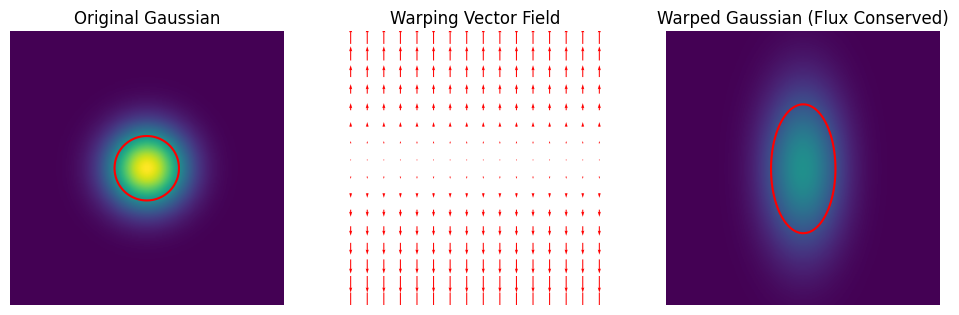

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

# Create a 2D Gaussian distribution
def generate_gaussian(size, center, sigma):
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size), indexing='ij')
    gauss = np.exp(-((x - center[0]) ** 2 + (y - center[1]) ** 2) / (2 * sigma ** 2))
    return gauss

# Warp the coordinates with squeezing in x and stretching in y
def generate_offset(size, squeeze_factor, stretch_factor):
    x, y = np.meshgrid(np.linspace(0, size - 1, size), np.linspace(0, size - 1, size), indexing='ij')
    offset_x = (x - size // 2) * (squeeze_factor - 1)
    offset_y = (y - size // 2) * (stretch_factor - 1)
    return np.stack((offset_x, offset_y), axis=-1)

# Resample the data with flux conservation
def warp_with_flux_conservation(data, offset):
    size = data.shape[0]
    x, y = np.meshgrid(np.arange(size), np.arange(size), indexing='ij')
    warped_x = x - offset[..., 0]
    warped_y = y - offset[..., 1]

    # Compute Jacobian components
    dx_dx = np.gradient(warped_x, axis=0)
    dx_dy = np.gradient(warped_x, axis=1)
    dy_dx = np.gradient(warped_y, axis=0)
    dy_dy = np.gradient(warped_y, axis=1)

    # Compute Jacobian determinant
    jacobian_determinant = dx_dx * dy_dy - dx_dy * dy_dx
    jacobian_determinant[np.abs(jacobian_determinant) < 1e-6] = 1.0  # Regularization

    # Adjust the data
    adjusted_data = data * jacobian_determinant

    # Resample the data
    coords = np.array([warped_x.ravel(), warped_y.ravel()])
    resampled_data = map_coordinates(adjusted_data, coords, order=1, mode='nearest').reshape(data.shape)

    return resampled_data, warped_x, warped_y

# Main script
size = 256
gaussian = generate_gaussian(size, center=(0, 0), sigma=0.2)
offset = generate_offset(size, squeeze_factor=1, stretch_factor=1.5)

# Warp the data
warped_data, warped_x, warped_y = warp_with_flux_conservation(gaussian, offset)

# Subsample the vector field for better visualization
subsample = 16
step = size // subsample
x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size), indexing='ij')
sub_x = x[::step, ::step]
sub_y = y[::step, ::step]
sub_u = offset[::step, ::step, 0]
sub_v = offset[::step, ::step, 1]


vmaxforplot = np.max([[np.max(gaussian), np.max(warped_data)]])

# Visualize the results
fig, axs = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1, 1], 'wspace': 0.2})

# Original data
axs[0].imshow(gaussian.T, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis', vmin=0, vmax=vmaxforplot)
axs[0].contour(x,y,gaussian, levels=[0.5*np.max(gaussian)], colors=['red'])
axs[0].set_title("Original Gaussian")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# Vector field (offset)
axs[1].quiver(sub_x, sub_y, sub_u, sub_v, color='red', angles='xy', scale_units='xy')
axs[1].set_title("Warping Vector Field")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

# Warped data
axs[2].imshow(warped_data.T, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis', vmin=0, vmax=vmaxforplot)
axs[2].contour(x,y,warped_data, levels=[0.5*np.max(warped_data)], colors=['red'])
axs[2].set_title("Warped Gaussian (Flux Conserved)")
axs[2].set_xlabel("x'")
axs[2].set_ylabel("y'")

# no axis for all
for ax in axs:
    ax.axis('off')
    ax.set_aspect(1.)


plt.tight_layout()
fig.savefig('flux_conserv_0.pdf', dpi=300, bbox_inches='tight')
